In [2]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

'3.1.3'

In [3]:
from google.cloud import storage

In [4]:
%%time
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/jasmeetsingh/df_final_for_analysis/')

# df = df.sample(fraction = 0.001, seed = 42).cache()

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 8.59 s


22/12/08 01:56:58 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
@F.udf
def get_date(date_):
    date = date_[4:10] + " " + date_[-4:]
    from datetime import datetime
    datetime_str = date
    return str(datetime.strptime(datetime_str, '%b %d %Y'))

df = df.withColumn("created_at_date", get_date("created_at"))

In [6]:
%%time
df.count()

CPU times: user 29.3 ms, sys: 5.83 ms, total: 35.1 ms
Wall time: 19.5 s


3119357

In [7]:
df.limit(5).toPandas()

,created_at,id,geo_coordinates,user_name,followers_count,verified_user,user_location,user_description,reply_count,retweet_count,retweeted_status,tweet_text,text,created_at_date
0,Mon Aug 08 20:25:07 +0000 2022,1556738297606569994,None,Nebula 🛹☮️,9247,False,ShitholeImmigrant,Proud Liberal #Betocrat #BetoForGovernor #Vote...,20,105,"(None, Mon Aug 08 15:17:00 +0000 2022, None, (...",School choice critics worry that the policy co...,rt @texastribune: school choice critics worry ...,2022-08-08 00:00:00
1,Mon Aug 08 20:25:07 +0000 2022,1556738297526902787,None,Sydney Rey Franklin,457,False,"Cincinnati, OH",@enquirer real estate enterprise reporter // F...,0,1,"(None, Fri Aug 05 12:34:28 +0000 2022, None, (...",Design LAB: Grade school students learn to be ...,rt @cweiser: design lab: grade school students...,2022-08-08 00:00:00
2,Mon Aug 08 20:25:20 +0000 2022,1556738350953861121,None,Kate F,661,False,California,An aware & concerned American.,0,6,"(None, Tue Aug 02 13:16:19 +0000 2022, None, (...",If the United States aims to outcompete other ...,rt @csetgeorgetown: if the united states aims ...,2022-08-08 00:00:00
3,Mon Aug 08 20:25:22 +0000 2022,1556738360412086280,None,David Engelson,692,False,"Staten Island, NY","Cogito, ergo sum. Wife : @CeliaEngelson. Daugh...",113,352,"(None, Mon Aug 08 19:52:38 +0000 2022, [0, 140...",I’ve had a few teachers ask me for personalize...,rt @hiitaylorblake: i’ve had a few teachers as...,2022-08-08 00:00:00
4,Mon Aug 08 20:25:25 +0000 2022,1556738374286934018,None,Kathryn Moore,186,False,None,None,24,364,"(None, Mon Aug 08 18:02:16 +0000 2022, None, (...",BREAKING: A coalition of charter schools filed...,rt @deangeliscorey: breaking: a coalition of c...,2022-08-08 00:00:00


## Where are these Twitterers (all of them, not just influencers) located?

### Visualize the geographical distribution

In [8]:
df_geo = df.filter('user_location is not null and followers_count is not null').select(['user_location', 'user_name', 'followers_count'])
df_geo.count()

1931676

In [9]:
df_geo_pd = df_geo.groupby('user_name').agg(first('user_location').alias('location'), max('followers_count').alias('followers'))\
                    .sample(fraction = 0.05, seed = 42).toPandas()

In [10]:
len(df_geo_pd)

43403

In [11]:
!pip install geopy
clear_output(wait = False)

In [12]:
from geopy.geocoders import Nominatim

In [13]:
geolocator = Nominatim(user_agent = 'BDPFinalProject')
location = geolocator.geocode("nyc")

In [14]:
location.address.split(', ')[-1]

'United States'

In [15]:
t = df_geo_pd.head(20)

In [16]:
!pip install geosky
clear_output(wait = False)
from geosky import geo_plug
country_names = geo_plug.all_CountryNames()

[Info] Loading Data
[Info] Loading Data completed


In [17]:
import time
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

locations_list = []

def get_country(location):
    if('US' in location or 
       'us' in location or 
       'United States' in location or 
       'USA' in location or 
       'United States of America' in location):
        return 'United States of America'
    
    global locations_list
    for i in locations_list:
        if(i in location):
            return i
    
    if(is_ascii(location) == False):
        return "N/A"
    if(location in country_names):
        return location
    try:
        res = geolocator.geocode(location)
    except:
        return "N/A"
    if(res == None):
        return "N/A"
    
    if(res.address.split(', ')[-1] == 'United States'):
        locations_list.append('United States')
        return 'United States of America'
    locations_list.append(res.address.split(', ')[-1])
    return res.address.split(', ')[-1]

In [18]:
# %%time

# from tqdm import tqdm
# tqdm.pandas()

# df_geo_pd['country'] = df_geo_pd['location'].progress_apply(get_country)
# clear_output(wait = False)

In [19]:
# df_geo_pd.to_csv('geo_data.csv', index = False)

In [21]:
df_geo_pd = pd.read_csv('geo_data.csv')
tem = pd.DataFrame(df_geo_pd['country'].value_counts()).reset_index()
tem.rename(columns = {'index': 'Name of the Country', 'country': 'Number of Users'}, inplace = True)
tem.head(10)
tem.rename(columns = {'Name of the Country' : 'index', 'Number of Users': 'country'}, inplace = True)

In [22]:
import geopandas
!pip install geoplot
clear_output(wait = False)
import geoplot
import mapclassify

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


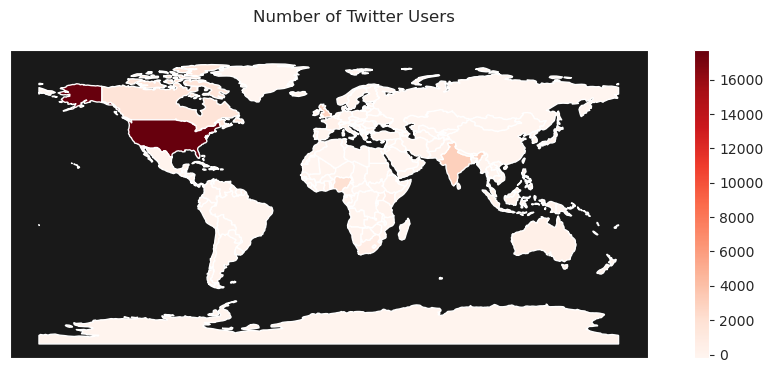

In [23]:
# ref = https://swdevnotes.com/python/2020/display-world-map-country-data/
import seaborn as sns
sns.set_style(style = 'dark')
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('Number of Twitter Users')
world = pd.merge(left = world, right = tem, left_on = 'name', right_on = 'index', how = 'left')
world["country"].fillna(-200, inplace = True) 
ax.set_facecolor(plt.cm.binary(0.9))
plt.tick_params( axis='both', which='both',
                 bottom=False, left = False, 
                 labelleft = False, labelbottom = False
               )

# reds' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 
# 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 
# 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges',
# 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
# 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
# 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
# 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 
# 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 
# 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 
# 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 
# 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 
# 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
# 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 
# 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 
# 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
# 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r',
# 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
world.plot(column = 'country', cmap = 'Reds', ax = ax, legend = True)
plt.show()

### Using coordinates data

In [24]:
df_coordinates = df.filter('geo_coordinates is not null and followers_count is not null').select(['geo_coordinates', 'user_name', 'followers_count'])
df_coordinates.count()

1443

In [25]:
df_coordinates_pd = df_coordinates.toPandas()

In [26]:
df_coordinates_pd.head()

,geo_coordinates,user_name,followers_count
0,"[49.13055808, -123.1788327]",RA McMath,794
1,"[40.007855, -83.021452]",ASABE.org,3050
2,"[43.55889662, -80.26834057]",Team SKS MartialArts,216
3,"[41.127216, -96.250421]",Nationwide Job Search,498
4,"[13.36094689, 78.57329071]",Manikanta Kamatam,259


In [27]:
df_coordinates_pd[['x','y']] = pd.DataFrame(df_coordinates_pd.geo_coordinates.tolist())

In [28]:
df_coordinates_pd.head()

,geo_coordinates,user_name,followers_count,x,y
0,"[49.13055808, -123.1788327]",RA McMath,794,49.130558,-123.178833
1,"[40.007855, -83.021452]",ASABE.org,3050,40.007855,-83.021452
2,"[43.55889662, -80.26834057]",Team SKS MartialArts,216,43.558897,-80.268341
3,"[41.127216, -96.250421]",Nationwide Job Search,498,41.127216,-96.250421
4,"[13.36094689, 78.57329071]",Manikanta Kamatam,259,13.360947,78.573291


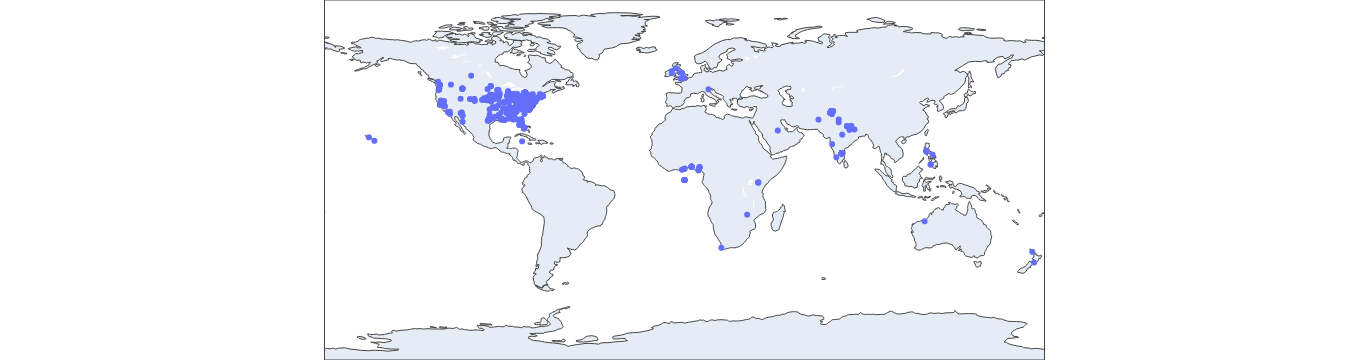

<Figure size 800x480 with 0 Axes>

In [49]:
!pip install plotly
clear_output(wait = False)
import plotly.express as px
import geopandas as gpd
from matplotlib.pyplot import figure

geo_df = df_coordinates_pd
figure(figsize=(10, 6), dpi=80)

fig = px.scatter_geo(geo_df,
                    lat=geo_df.x,
                    lon=geo_df.y,
                    hover_name="user_name")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?

In [ ]:
top_countries = pd.DataFrame(df_geo_pd['country'].value_counts()).reset_index().head(5)
countries = list(top_countries['index'].values)
countries = countries[:3]

In [ ]:
df_geo_pd.head()

In [ ]:
df_geo_pd = df_geo_pd.fillna('N/A')
df_geo_pd_df = spark.createDataFrame(df_geo_pd) 
df_geo = df.filter('user_location is not null and followers_count is not null')
df_geo = df_geo.filter('text like "%policy%"').select(['user_location', 'user_name', 'followers_count', 'created_at_date'])
df_geo = df_geo.join(df_geo_pd_df, df_geo.user_name == df_geo_pd_df.user_name, how = 'left')

In [ ]:
@F.udf
def get_month(date_):
    return str(date_)[5:7]

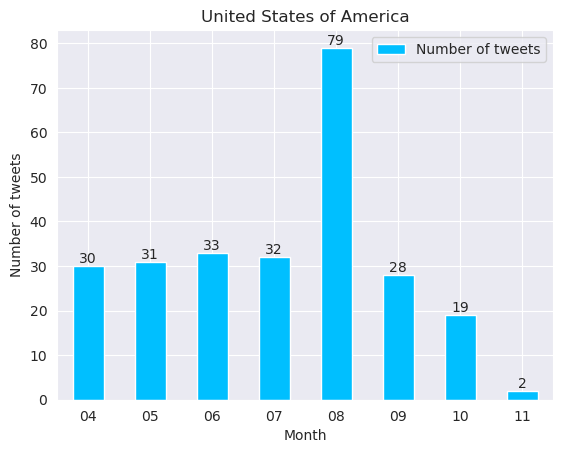

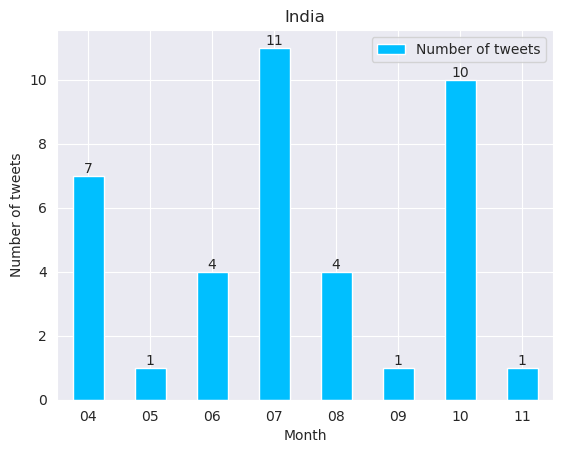

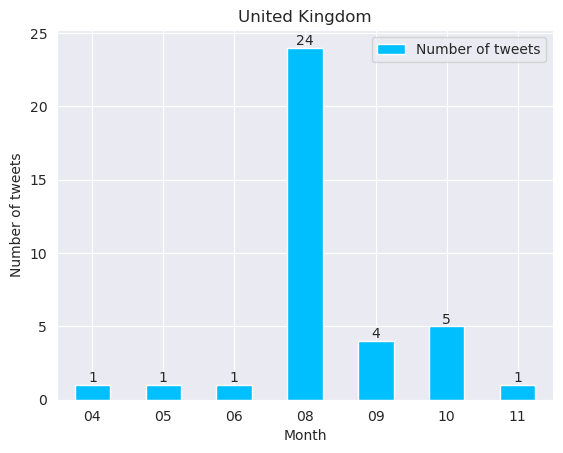

In [ ]:
for i in countries:
    #flair pallete
    df_geo_country = df_geo.filter('country == "' + i + '"') 
    df_geo_country = df_geo_country.withColumn("month", get_month('created_at_date'))
    emergenced_df = (df_geo_country.groupby('month').agg(count('*').alias('Number of tweets'))).toPandas().sort_values(by = 'month').set_index(keys = 'month', drop = True)
    fig = emergenced_df.plot(kind = 'bar', title = i, color= 'deepskyblue', grid = True)
    fig.set_xlabel('Month')
    fig.set_ylabel('Number of tweets')
    fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
    plt.xticks(rotation = 0)
    plt.show()

In [ ]:
df_ = df.filter('text like "%book ban%"').select(['user_location', 'user_name', 'followers_count', 'created_at_date'])
df_ = df_.withColumn("month", get_month('created_at_date'))
emergenced_df = (df_.groupby('month').agg(count('*').alias('Number of tweets'))).toPandas().sort_values(by = 'month').set_index(keys = 'month', drop = True)

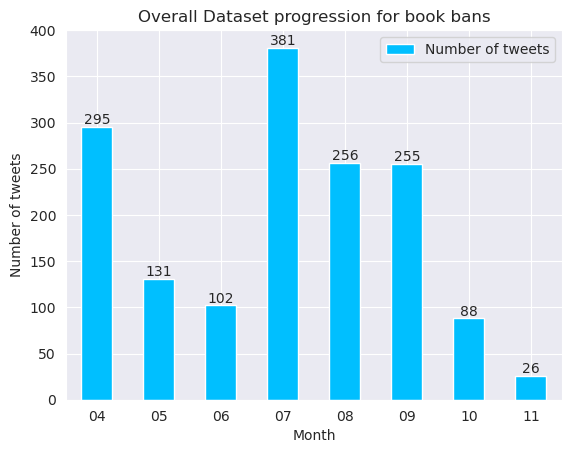

In [ ]:
fig = emergenced_df.plot(kind = 'bar', title = 'Overall Dataset progression for book bans', color= 'deepskyblue', grid = True)
fig.set_xlabel('Month')
fig.set_ylabel('Number of tweets')
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.xticks(rotation = 0)
plt.show()

## What are the timelines of these tweets? Do you see significant peaks and valleys?
### Do you see any data collection gaps?
### Plot the timelines of these tweets

In [ ]:
df_timelines = df.select(['created_at_date', 'id']).filter("created_at is not null")

In [ ]:
df_timelines.printSchema()

root
 |-- created_at_date: string (nullable = true)
 |-- id: long (nullable = true)



In [ ]:
df_timelines.count()

3119357

In [ ]:
df_timelines.limit(5).show()

+-------------------+-------------------+
|    created_at_date|                 id|
+-------------------+-------------------+
|2022-04-22 00:00:00|1517509956181782529|
|2022-04-22 00:00:00|1517509969507143682|
|2022-04-22 00:00:00|1517509991779176449|
|2022-04-22 00:00:00|1517510005242486785|
|2022-04-22 00:00:00|1517510013014605824|
+-------------------+-------------------+



In [ ]:
df_timelines_pd = df_timelines.groupby('created_at_date').agg(count('id').alias("count_id")).toPandas()

In [ ]:
len(df_timelines_pd)

216

In [ ]:
df_timelines_pd['created_at_date'] = pd.to_datetime(df_timelines_pd['created_at_date'])
df_timelines_pd['year'] = df_timelines_pd['created_at_date'].dt.year
df_timelines_pd['month'] = df_timelines_pd['created_at_date'].dt.month
df_timelines_pd['dayName'] = df_timelines_pd['created_at_date'].dt.day_name()
df_timelines_pd['dayCode'] = df_timelines_pd['created_at_date'].dt.dayofweek

In [ ]:
df_timelines_pd.head()

,created_at_date,count_id,year,month,dayName,dayCode
0,2022-06-23,21330,2022,6,Thursday,3
1,2022-05-08,19185,2022,5,Sunday,6
2,2022-10-06,11445,2022,10,Thursday,3
3,2022-07-07,13681,2022,7,Thursday,3
4,2022-10-18,15785,2022,10,Tuesday,1


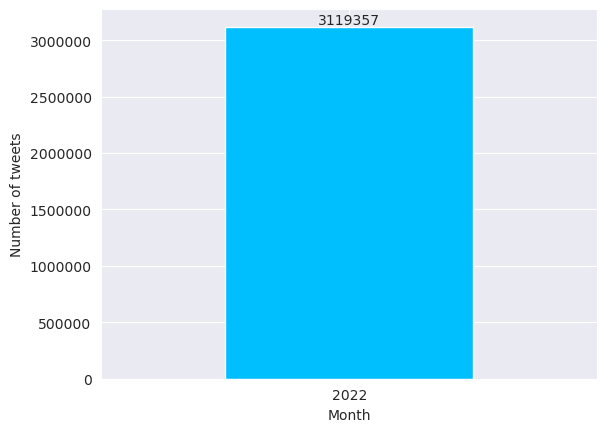

In [ ]:
fig = df_timelines_pd.groupby(by = 'year').sum('count_id')['count_id'].plot(kind = 'bar', color= 'deepskyblue', grid = True)
# fig = emergenced_df.plot(kind = 'bar', title = 'Overall Dataset progression for book bans', color= 'deepskyblue', grid = True)
fig.set_xlabel('Month')
fig.set_ylabel('Number of tweets')
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

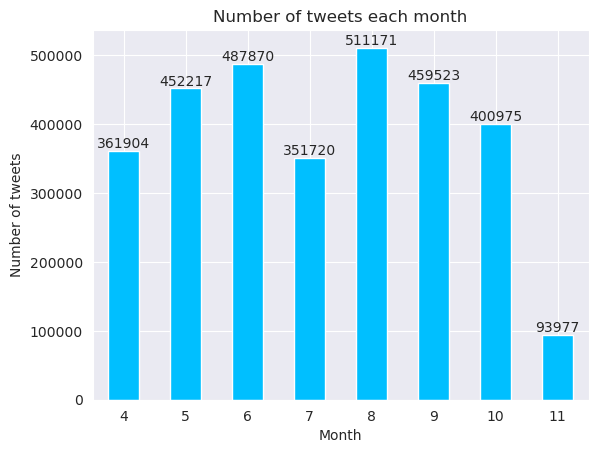

In [ ]:



fig = df_timelines_pd.groupby(by = 'month').sum('count_id')['count_id'].plot(kind = 'bar', color= 'deepskyblue', grid = True, title = 'Number of tweets each month')
# fig = emergenced_df.plot(kind = 'bar', title = 'Overall Dataset progression for book bans', color= 'deepskyblue', grid = True)
fig.set_xlabel('Month')
fig.set_ylabel('Number of tweets')
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.xticks(rotation = 0 )
plt.ticklabel_format(style='plain', axis='y')
plt.show()

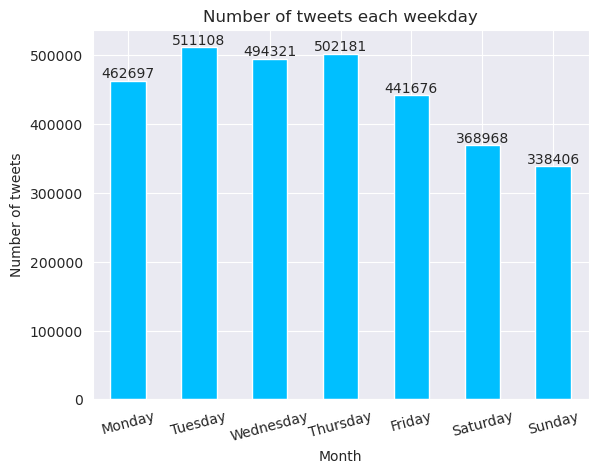

In [ ]:
fig = df_timelines_pd.groupby(by = 'dayName').sum('count_id').sort_values(by = 'dayCode')['count_id'].plot(kind = 'bar', color= 'deepskyblue', grid = True, title = 'Number of tweets each weekday')
# fig = emergenced_df.plot(kind = 'bar', title = 'Overall Dataset progression for book bans', color= 'deepskyblue', grid = True)
fig.set_xlabel('Month')
fig.set_ylabel('Number of tweets')
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.xticks(rotation = 15)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

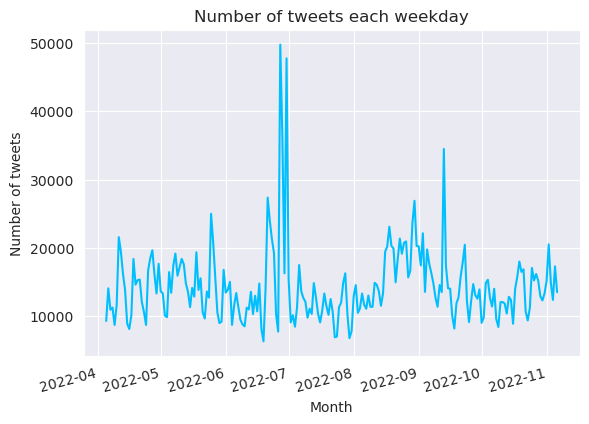

In [ ]:
fig = df_timelines_pd.groupby(by = 'created_at_date').sum('count_id').sort_values(by = 'dayCode')['count_id'].plot(color= 'deepskyblue', grid = True, title = 'Number of tweets each weekday')
# fig = emergenced_df.plot(kind = 'bar', title = 'Overall Dataset progression for book bans', color= 'deepskyblue', grid = True)
fig.set_xlabel('Month')
fig.set_ylabel('Number of tweets')
# fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.xticks(rotation = 15)
plt.ticklabel_format(style='plain', axis='y')
plt.show()